In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, log_loss, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Deep Learning approaches

The DL models we are building will be a simple an LSTM RNN model.
The model will have 2 LSTM Layers with a Dense Layer at the bottom.  

Here we will be doing 2 instances of the DL model.
One trained with the normal distribution of the data, the other with the Oversampled dangerous class.

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.callbacks import EarlyStopping, History

import tensorflow.keras as K
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Inital data prep

Even though we have processed the dl_data.  
We still need to process it further into the sequences to be feed into the LSTM RNN network.

In [ ]:
dl_data = pd.read_csv('/content/drive/MyDrive/grab/dl_data.csv')

In [ ]:
dl_data

,bookingID,Accuracy,Bearing,gyro_x,gyro_y,gyro_z,second,Speed,label,acc_vec,acc_y
0,0,12.0,143.298294,-0.016245,-0.094040,0.070732,0.0,3.442991,0,10.176551,9.941461
1,0,8.0,143.298294,-0.047092,-0.078874,0.043187,1.0,0.228454,0,10.059553,9.835590
2,0,8.0,143.298294,-0.028965,-0.032652,0.015390,2.0,0.228454,0,9.503762,9.270792
3,0,8.0,143.298294,-0.022413,0.005049,-0.025753,3.0,0.228454,0,9.830320,9.548032
4,0,8.0,143.298294,-0.014297,-0.046206,0.021902,4.0,0.228454,0,9.967466,9.853534
...,...,...,...,...,...,...,...,...,...,...,...
15161680,1709396983975,8.0,199.547104,-0.012879,0.015905,-0.007625,559.0,1.035811,1,9.796805,8.949738
15161681,1709396983975,8.0,199.547104,-0.006455,0.005278,-0.000082,560.0,1.035811,1,9.772852,8.929102
15161682,1709396983975,12.0,199.547104,0.044719,0.032351,-0.018600,561.0,0.302453,1,9.917047,8.914597
15161683,1709396983975,12.0,199.547104,0.053263,0.029213,-0.016357,562.0,0.302453,1,9.988606,8.951382


In [ ]:
# Dropping second to take it as 1 continous sequence
# Doing this because interpolating the data at this time is probably not realistic
dl_data = dl_data.drop(['second'], axis=1)

In [ ]:
# Creating new df by bookingID
dl = dl_data.set_index(['bookingID'])

# Grabbing the labels
l = dl.groupby(['bookingID'])['label'].max()
l = l.values
# Grabbing the data
d = [i[1].drop(['label'], axis=1).values for i in tuple(dl.groupby(['bookingID']))]
d = np.array(d)

print(f"Looking at d")
display(d)

pad_max = np.max([len(i) for i in d])
print(f"Pad max: {pad_max}")

Looking at d


array([array([[ 1.20000000e+01,  1.43298294e+02, -1.62447500e-02, ...,
         3.44299054e+00,  1.01765505e+01,  9.94146118e+00],
       [ 8.00000000e+00,  1.43298294e+02, -4.70918786e-02, ...,
         2.28454471e-01,  1.00595525e+01,  9.83558960e+00],
       [ 8.00000000e+00,  1.43298294e+02, -2.89650726e-02, ...,
         2.28454471e-01,  9.50376166e+00,  9.27079163e+00],
       ...,
       [ 8.00000000e+00,  1.31808448e+00, -9.69017794e-03, ...,
         1.65436668e+01,  1.02945232e+01,  1.02233368e+01],
       [ 8.00000000e+00,  1.31808448e+00, -4.23354729e-02, ...,
         1.65436668e+01,  1.04173120e+01,  1.02342529e+01],
       [ 8.00000000e+00,  1.31808448e+00,  2.09582788e-02, ...,
         1.75009499e+01,  9.05307233e+00,  8.78210754e+00]]),
       array([[ 4.00000000e+00,  2.52000000e+02,  1.61268410e-02, ...,
         4.75642700e+00,  1.05700997e+01,  1.01741410e+01],
       [ 4.00000000e+00,  2.36000000e+02,  3.74722200e-02, ...,
         4.93721100e+00,  9.37949522e+00

Pad max: 5954


In [ ]:
display(f"d shape: {d.shape}")
display(f"l shape: {l.shape}")

display(d[0])
display(l[0])

'd shape: (19899,)'

'l shape: (19899,)'

array([[ 1.20000000e+01,  1.43298294e+02, -1.62447500e-02, ...,
         3.44299054e+00,  1.01765505e+01,  9.94146118e+00],
       [ 8.00000000e+00,  1.43298294e+02, -4.70918786e-02, ...,
         2.28454471e-01,  1.00595525e+01,  9.83558960e+00],
       [ 8.00000000e+00,  1.43298294e+02, -2.89650726e-02, ...,
         2.28454471e-01,  9.50376166e+00,  9.27079163e+00],
       ...,
       [ 8.00000000e+00,  1.31808448e+00, -9.69017794e-03, ...,
         1.65436668e+01,  1.02945232e+01,  1.02233368e+01],
       [ 8.00000000e+00,  1.31808448e+00, -4.23354729e-02, ...,
         1.65436668e+01,  1.04173120e+01,  1.02342529e+01],
       [ 8.00000000e+00,  1.31808448e+00,  2.09582788e-02, ...,
         1.75009499e+01,  9.05307233e+00,  8.78210754e+00]])

0

## Inital LSTM RNN training

Here we will be using a padding to fill the values with 0.
Then we will be cutting off the last 954 data points to be used as the seqence to be fed into the model.  

This experiment we will be using the natural distribution of the unbalanced class for training.

In [ ]:
# Padding the sequences
d = sequence.pad_sequences(d, maxlen=pad_max)
d = d[:, 5000:, :] # last 1K data
d.shape

(19899, 954, 8)

In [ ]:
# Creating the train test split for the data
x_train, x_test, y_train, y_test = train_test_split(d, l.reshape(-1, 1))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(14924, 954, 8)
(4975, 954, 8)
(14924, 1)
(4975, 1)


In [ ]:
x_train

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  4,   0,   0, ...,   0,   9,   9],
        [  4,   0,   0, ...,   0,  10,  10],
        [  4,   0,   0, ...,   0,   9,   9]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  7, 168,   0, ...,   2,   9,   8],
        [  7, 187,   0, ...,   3,   9,   9],
        [  9, 193,   0, ...,   4,   9,   8]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  5,  76,   0, ...,  22,   9,   0],
        [  5, 109,   0, ...,  24,   8,   0],
        [  5, 119,   0, ...,  25,   9,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0

In [ ]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
# Making an LSTM model
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, LSTM, TimeDistributed
from keras.models import Model, Sequential

model = Sequential()

model.add(LSTM(500, return_sequences=True, batch_input_shape=(None, 954, 8)))
model.add(LSTM(500, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 954, 500)          1018000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dense (Dense)                (None, 2)                 1002      
Total params: 3,021,002
Trainable params: 3,021,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs=20, callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-6)], batch_size=16, validation_data=(x_test, y_test))

Epoch 1/20
933/933 [==============================] - 309s 331ms/step - loss: 0.6986 - binary_crossentropy: 0.6986 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 2/20
933/933 [==============================] - 309s 331ms/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 3/20
933/933 [==============================] - 311s 334ms/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932


In [ ]:
model.save('/content/drive/MyDrive/grab/lstm.h5', save_format='h5')

In [ ]:
preds = model.predict_classes(x_test)
preds

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 1, 0, ..., 1, 1, 0])

              precision    recall  f1-score   support

           0       0.75      0.95      0.83      3710
           1       0.27      0.06      0.10      1265

    accuracy                           0.72      4975
   macro avg       0.51      0.50      0.47      4975
weighted avg       0.63      0.72      0.65      4975

[[3511  199]
 [1191   74]]


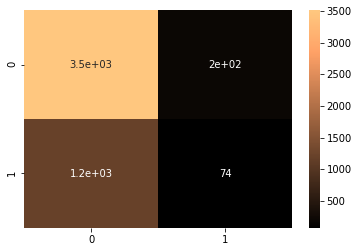

In [ ]:
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
print(cm)
sns.heatmap(cm, annot=True, cmap='copper')

## 2nd Experiment trying to oversample and balance the dataset

In this section, we balanaced the data using RandomOverSampling from imblearn, oversampling on the dagerous (1 label) data points.  

We also used a much longer sequence length of the last 1954 data points for the sequence.

In [ ]:
d = sequence.pad_sequences(d, maxlen=pad_max)
d.shape
d = d[:, 4000:, :] # last 1K data

# Creating the train test split for the data
x_train, x_test, y_train, y_test = train_test_split(d, l.reshape(-1, 1))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42, ratio=0.5, return_indices=True)
ros.fit_resample(x_train[:, :, 0], y_train)
x_train = x_train[ros.sample_indices_]
y_train = y_train[ros.sample_indices_]

print(x_train.shape)
print(y_train.shape)

(14924, 1954, 8)
(4975, 1954, 8)
(14924, 1)
(4975, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(16842, 1954, 8)
(16842, 1)


In [ ]:
# Making an LSTM model
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, LSTM, TimeDistributed
from keras.models import Model, Sequential

model = Sequential()

model.add(LSTM(500, return_sequences=True, batch_input_shape=(None, 1954, 8)))
model.add(LSTM(500, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1954, 500)         1018000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1002      
Total params: 3,021,002
Trainable params: 3,021,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs=20, callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-6)], batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
527/527 [==============================] - 353s 671ms/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 2/20
527/527 [==============================] - 353s 670ms/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 3/20
527/527 [==============================] - 353s 670ms/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931


In [ ]:
model.save('/content/drive/MyDrive/grab/lstm_balanced.h5', save_format='h5')

In [ ]:
preds = model.predict_classes(x_test)
preds

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 1, 1, ..., 1, 1, 1])

              precision    recall  f1-score   support

           0       0.67      0.06      0.10      3691
           1       0.25      0.92      0.40      1284

    accuracy                           0.28      4975
   macro avg       0.46      0.49      0.25      4975
weighted avg       0.56      0.28      0.18      4975

[[ 207 3484]
 [ 102 1182]]


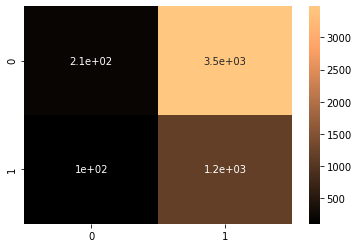

In [ ]:
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
print(cm)
sns.heatmap(cm, annot=True, cmap='copper')